# Analyzing Emotion and Tone of Financial Complaints with Watson NLP

This notebook demonstrates how to analyze financial customer complaints using Watson NLP.

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), an U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains a consumer’s narrative description of their experience if the consumer opts to share this information publicly and after the CFPB has taken steps to remove all personal information. In this notebook, you will focus on complaints that contain narrative descriptions to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.

## What you'll learn in this notebook

Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Tone classification** with the _Tone classification model_ for English (`ensemble_classification-workflow_en_tone-stock`). This workflow model classifies the tone of a document as *excited*, *frustrated*, *sad*, *polite*, *impolite*, *satisfied* and *sympathetic*.
- **Emotion classification** with the _Emotion classification model_ for English (`ensemble_classification-workflow_en_emotion-stock`). This workflow model classifies the emotion of a document into *anger*, *disgust*, *fear*, *joy* or *sadness*. 



## Table of Contents


1. [Before you start](#beforeYouStart)
2. [Load the complaints](#loadData)
3. [Tone classification](#tone)
4. [Emotion classification](#emotion)
5. [Summary](#summary)


<a id="beforeYouStart"></a>
## Before you start

You can step through the notebook execution cell by cell, by selecting Shift-Enter or you can execute the entire notebook by selecting **Cell -> Run All** from the menu. 

**Note:** If you have other notebooks currently running with the _NLP Environment_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.


Begin by importing and initializing some helper libraries that are used throughout the notebook.

In [2]:
import os
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

In [3]:
import watson_nlp

<a id="loadData"></a>
## Load the complaints

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. For this notebook, the complaints for one month will be downloaded and only those that contain the consumer narrative text. The data is exported in CSV format. The URL to retrieve this data is:

In [4]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"

Read the data into a dataframe.

You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In the analysis, you will focus on the *Product* column and the column with the complaint text *Consumer complaint narrative*.

In [5]:
df_all = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

# In this example, we take only the first 1000 complaints in the dataset for further analysis. 
# Set df to df_all to run on the complete dataset.
df_small = df_all.head(1000)
df = df_small
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/16/21,Mortgage,Other type of mortgage,Closing on a mortgage,NaN,I have spoken with the representative for guaranteed rate with no positive results. this company was very negligent and handling my loan process which called me to lose XXXX and to lose the home that I was trying to purchase. they would wait until the day of clothes or one day before close and continue to ask for a documentation that I sent in to them every single time. They would wait 3 to 4 ...,NaN,GUARANTEED RATE INC.,GA,30233,NaN,Consent provided,Web,03/16/21,Closed with explanation,Yes,NaN,4217655
1,03/23/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Their investigation did not fix an error on your report,"Im submitting this complaint against EQUIFAX due to their total disregard for my consumer rights under the FCRA/FCBA/FDCPA. For several months now, I've been disputing inaccurate and unverifiable information showing up on my credit report by this company. I have requested intimate information about the alleged accounts, including a copy of an agreement with my signature on it, but I have yet t...",NaN,"EQUIFAX, INC.",TX,77449,NaN,Consent provided,Web,03/23/21,Closed with explanation,Yes,NaN,4240468
2,03/23/21,"Money transfer, virtual currency, or money service",Mobile or digital wallet,Fraud or scam,NaN,"I was approached by a family member about lending them some money through XXXX on Chase, When i went to my bank it had already been sent from my account to a "" manny '' with an account linked by the phone number XXXX XXXX XXXX XXXX, They sent themselves 2 payments, one of {$350.00} and another for {$500.00} I contacted my family member right away and they confirmed that someone had assumed the...",NaN,JPMORGAN CHASE & CO.,CA,94116,NaN,Consent provided,Web,03/23/21,Closed with explanation,Yes,NaN,4237488


You can look at all products that are available in the data set to do further analysis around these product groups.

<Axes: ylabel='Product'>

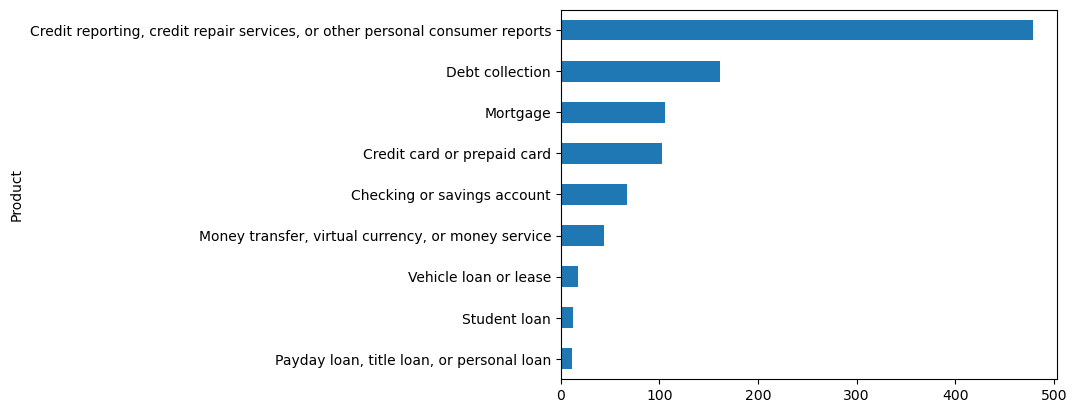

In [6]:
df['Product'].value_counts().sort_values().plot(kind='barh') 

<a id="tone"></a>
## Tone classification

The tone classification model predicts the most prevalent tones of a document text. Available tones are *excited*, *frustrated*, *sad*, *polite*, *impolite*, *satisfied* and *sympathetic*. Each tone is assigned a confidence, so we can either use the highest-rated tone or we can assign several tones to a document e.g. by taking all tones whose confidence exceeds a certain threshold.

In customer complaints, you would expect the tone to be *sad* or *frustrated*. Let's see if the analysis confirms this assumption.

Start with loading the tone workflow model for English:

In [7]:
tone_model = watson_nlp.load('ensemble_classification-workflow_en_tone-stock')

Create a helper function to run the tone analysis on a single complaint. It will return all tones that have a confidence that is higher than 1/7.

In [8]:
def classify_tone(complaint_text):
    # run the tone model 
    tone_result = tone_model.run(complaint_text)
    tone_classes = [c.to_dict() for c in tone_result.classes]
    tone_conf = [c['class_name'] for c in tone_classes if c['confidence'] > 0.14]
    return tone_conf

Run the tone classification on the dataframe and show the tones with the product and the complaint text. **Note:** This cell will run for several minutes. <br/>  For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. You can also use `apply` directly, i.e. `df[text_col].apply(..)`.

In [9]:
from tqdm.notebook import tqdm
tqdm.pandas(colour='green')

In [10]:
# run tone classification and create a dataframe holding the tones
tone = df[text_col].progress_apply(lambda text: classify_tone(text))
tone_df = pd.DataFrame(tone)
tone_df.rename(inplace=True, columns={text_col:'Tones'})
# combine with our complaint dataframe
text_tone_df = df[["Product", text_col]].merge(tone_df, how='left', left_index=True, right_index=True)
text_tone_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,Product,Consumer complaint narrative,Tones
0,Mortgage,I have spoken with the representative for guaranteed rate with no positive results. this company was very negligent and handling my loan process which called me to lose XXXX and to lose the home that I was trying to purchase. they would wait until the day of clothes or one day before close and continue to ask for a documentation that I sent in to them every single time. They would wait 3 to 4 ...,"[sad, polite, frustrated]"
1,"Credit reporting, credit repair services, or other personal consumer reports","Im submitting this complaint against EQUIFAX due to their total disregard for my consumer rights under the FCRA/FCBA/FDCPA. For several months now, I've been disputing inaccurate and unverifiable information showing up on my credit report by this company. I have requested intimate information about the alleged accounts, including a copy of an agreement with my signature on it, but I have yet t...","[sad, frustrated]"
2,"Money transfer, virtual currency, or money service","I was approached by a family member about lending them some money through XXXX on Chase, When i went to my bank it had already been sent from my account to a "" manny '' with an account linked by the phone number XXXX XXXX XXXX XXXX, They sent themselves 2 payments, one of {$350.00} and another for {$500.00} I contacted my family member right away and they confirmed that someone had assumed the...","[polite, sad]"
3,"Credit reporting, credit repair services, or other personal consumer reports","Hello, In XXXX oXXXX XXXX, I filed a dispute with the credit bureaus about the illegally reinserted collection account : XXXX XXXX account # XXXX I did some reading about credit reporting laws and under the FCRA ( A ) ( 5 ) ( B ), all reinserted accounts must be given a five day notice from the credit bureaus or it must be promptly deleted. and from my understanding if a consumer finds errors ...","[polite, sad]"
4,Checking or savings account,"Navy Federal has made it impossible to access my money but VERY easy to deposit. I had direct deposit with Navy Fed where I also have stimulus checks deposited. They locked me out of accessing my acct online and only can access by calling or going in person. However because in Texas it has been impossible to renew drivers licenses because of XXXX, I have not been able to access in person eithe...","[sad, polite, frustrated]"


### Display the tones of the complaints by product

Use the `explode` function to transform the tones list to separate rows for each tone. That way, you can count the occurrences for each tone in a subsequent step.

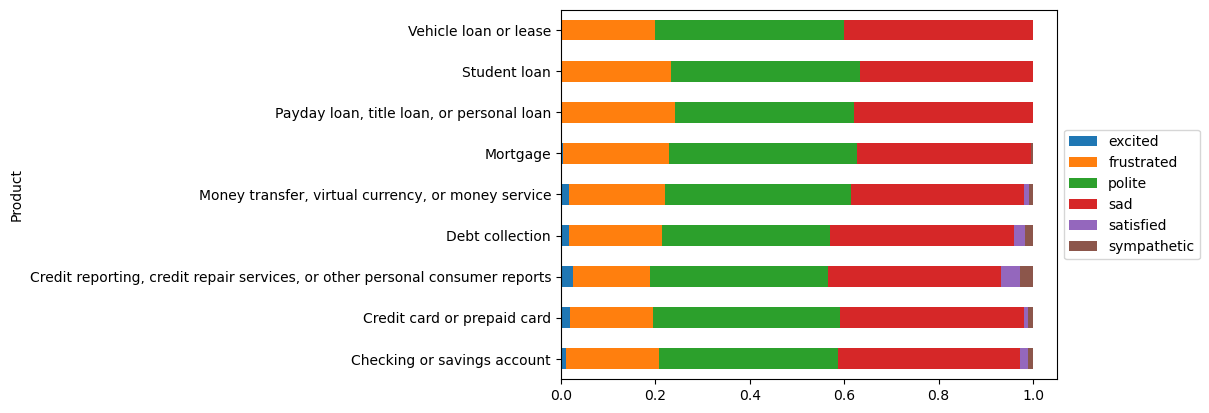

In [11]:
exp_tones = text_tone_df.explode('Tones')
# Count tone occurrences and use the relative frequency. unstack() creates a column for each tone.
unstacked = exp_tones.groupby('Product')['Tones'].value_counts(normalize=True).unstack()
# Plot a horizontal bar chart
unstacked.plot.barh(stacked=True).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

As expected, most complaints are classified as *sad* or *frustrated*, but still using a *polite* tone. There is no strong indicator that some products have a higher frustration rate than others.

<a id="emotion"></a>
## Emotion classification

The emotion classification model classifies the emotion of a document text. Available emotions are *anger*, *disgust*, *fear*, *joy* and *sadness*. As for tones, each emotion is assigned a confidence score. This time you will concentrate on the emotion with the highest confidence score.

You would expect *anger* and *sadness* to be the most prevalent emotions in the  complaint data set.

Start with loading the emotion workflow model for English:

In [13]:
emotion_model = watson_nlp.load('emotion_aggregated-workflow_en_stock')

Again, use a helper model to run the model on a single complaint. The classes are ordered by the confidence score. So you can use the first emotion as the prevalent emotion with the highest confidence.

In [16]:
def classify_emotion(complaint_text):
    # run the emotion model 
    emotion_result = emotion_model.run(complaint_text)
    # get the emotions with the confidence scores
    emotions_with_rank = emotion_result.emotion_predictions[0].emotion.to_dict()
    # return the emotion with the highest rank
    return max(emotions_with_rank, key=emotions_with_rank.get)

Run the emotion classification on the dataframe and show the highest ranked emotion with the product and the complaint text. **Note:** This cell will run for several minutes. <br/>  For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. You can also use `apply` directly, i.e. `df[text_col].apply(..)`.

In [17]:
# run emotion classification and create a dataframe holding the results
emotion = df[text_col].progress_apply(lambda text: classify_emotion(text))
emotion_df = pd.DataFrame(emotion)
emotion_df.rename(inplace=True, columns={text_col:'Emotion'})
# combine with our complaint dataframe
text_emotion_df = df[["Product", text_col]].merge(emotion_df, how='left', left_index=True, right_index=True)
text_emotion_df.head(3)

  0%|          | 0/1000 [00:00<?, ?it/s]

,Product,Consumer complaint narrative,Emotion
0,Mortgage,I have spoken with the representative for guaranteed rate with no positive results. this company was very negligent and handling my loan process which called me to lose XXXX and to lose the home that I was trying to purchase. they would wait until the day of clothes or one day before close and continue to ask for a documentation that I sent in to them every single time. They would wait 3 to 4 ...,sadness
1,"Credit reporting, credit repair services, or other personal consumer reports","Im submitting this complaint against EQUIFAX due to their total disregard for my consumer rights under the FCRA/FCBA/FDCPA. For several months now, I've been disputing inaccurate and unverifiable information showing up on my credit report by this company. I have requested intimate information about the alleged accounts, including a copy of an agreement with my signature on it, but I have yet t...",sadness
2,"Money transfer, virtual currency, or money service","I was approached by a family member about lending them some money through XXXX on Chase, When i went to my bank it had already been sent from my account to a "" manny '' with an account linked by the phone number XXXX XXXX XXXX XXXX, They sent themselves 2 payments, one of {$350.00} and another for {$500.00} I contacted my family member right away and they confirmed that someone had assumed the...",anger


### Display the emotion classification for each product group

In [ ]:
unstacked = text_emotion_df.groupby('Product')['Emotion'].value_counts(normalize=True).unstack()
unstacked.plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

As expected, the most prevalent emotions in the complaints are sadness and anger. In contrast to the tones classification, we picked only the emotion with the highest confidence score and not multiple emotions with a score above a certain threshold. *Sadness* seems to be the 'stronger' emotion overall, with higher confidences than *anger*. Companies might have a look at products or complaints showing emotion *anger*, because the customers that created those complaints might be 'pissed-off' most.

<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained models for tone and emotion classification and entity extraction. You learned how easy you can extract custom terms using dictionaries.

### Authors
Simone Zerfass IBM, Germany

Alexander Lang IBM, Germany

# <hr>
Copyright © 2021-2024 IBM. This notebook and its source code are released under the terms of the MIT License.